### Install dependencies

In [1]:
pip install scikit-learn scikit-image prettytable seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
import os
import PIL
import numpy as np
import pandas as pd
import random
import pickle
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier

### Load dataset

In [3]:
## Re-run EDA.ipynb if issues with loading pickle ##
# Load the pickled dataset (12335 augmented images; 128x128 pixels; binary labels - Fresh/Rotten; 80:20 train/test split)
X_train, X_test, y_train, y_test = pd.read_pickle(open("data_binary_128_split.pkl", "rb"))

### Data preprocessing

In [4]:
# Preprocess image data to flat 1D arrays before PCA and SVM
# Flatten X_train
X_train_flat = []
for image in X_train:
    image_flattened = image.flatten()
    X_train_flat.append(image_flattened)
X_train_flat = np.array(X_train_flat)

# Flatten X_test
X_test_flat = []
for image in X_test:
    image_flattened = image.flatten()
    X_test_flat.append(image_flattened)
X_test_flat = np.array(X_test_flat)

### Build and train the SVM classifier using grid search for hyperparameter tuning

In [5]:
# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('svc', SVC(random_state=42, probability=True))
])

# Define the parameter grid for the pipeline - updated based on previous GridSearch results
param_grid = {
    'pca__n_components': [50, 75, 100],
    'svc__C': [10, 40, 60, 100],
    'svc__kernel': ['rbf'], 
    'svc__gamma': ['scale']
}

# Instatiate GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit GridSearchCV object to the training data
%time grid_search.fit(X_train_flat, y_train)

CPU times: user 7h 25min 47s, sys: 3h 3min 23s, total: 10h 29min 11s
Wall time: 42min 51s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'pca__n_components': [50, 75, 100],
                         'svc__C': [10, 40, 60, 100], 'svc__gamma': ['scale'],
                         'svc__kernel': ['rbf']})

In [6]:
# Print the best hyperparameters and the corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'pca__n_components': 100, 'svc__C': 40, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best score: 0.9544991632222442


### Predict and evaluate performance on the train set (in-sample)

#### Predict on the train set (5-fold cross validation)

In [7]:
# Cross-val predict on train set
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train_flat, y_train, cv=5, method = 'predict')
y_train_pred_prob = cross_val_predict(grid_search.best_estimator_, X_train_flat, y_train, cv=5, method = 'predict_proba')

#### Model evaluation

AUC for fold 1: 0.99
AUC for fold 2: 0.99
AUC for fold 3: 0.99
AUC for fold 4: 0.99
AUC for fold 5: 0.99


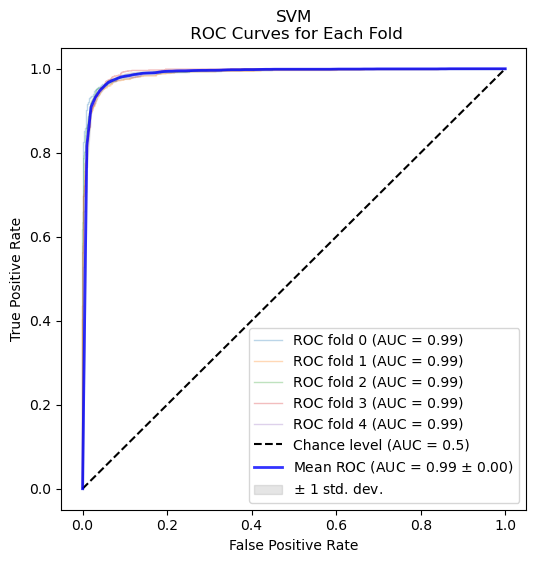

In [8]:
## Adapted from example in Scikit-Learn documentation - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# Initialize a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)
y_train_binary = (y_train == 'Rotten').astype(int)

# Define the True Positive Rate (TPR), Area Under Curve (AUC) lists
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Loop over each fold
for i, (train, test) in enumerate(cv.split(X_train_flat, y_train_binary)):

    # Compute ROC curve and ROC area for each fold using the `roc_curve` function
    fpr, tpr, _ = roc_curve(y_train_binary[test], y_train_pred_prob[test, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate the TPR
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    
    # Print AUC for this fold
    print(f"AUC for fold {i+1}: {roc_auc:.2f}")

    # Plot ROC for this fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC fold {i} (AUC = {roc_auc:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")

# Compute the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

# Plot the standard deviation around the mean ROC curve
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

# Set plot properties
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title="SVM\n ROC Curves for Each Fold")
ax.legend(loc="lower right")

# Show the plot
plt.show()

### Predict and evaluate performance on test set (out-of-sample)

#### Predict on test set

In [9]:
# Predict on test
y_test_pred = grid_search.best_estimator_.predict(X_test_flat)

#### Confusion matrix (SVM, test data)


Confusion Matrix (SVM, Test Data): 
+----------+-------------+-------------+
|          | Predicted 0 | Predicted 1 |
+----------+-------------+-------------+
| Actual 0 |     1205    |      51     |
| Actual 1 |      47     |     1164    |
+----------+-------------+-------------+


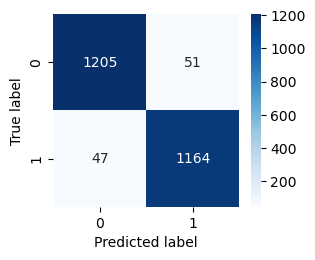

In [10]:
# Confusion matrix
data = confusion_matrix(y_test, y_test_pred)
tab2 = PrettyTable()
tab2.field_names = ["", "Predicted 0", "Predicted 1"]
tab2.add_row(["Actual 0", data[0][0], data[0][1]])
tab2.add_row(["Actual 1", data[1][0], data[1][1]])

print(f"\nConfusion Matrix (SVM, Test Data): \n{tab2}")

# Plot the confusion matrix using seaborn
plt.figure(figsize=(3,2.5))
sns.heatmap(data, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Performance Measures (SVM, test data)

In [11]:
# Performance scores
y_test_pred_scores = precision_recall_fscore_support(y_test, y_test_pred)

# Create performance measure table
tab3 = PrettyTable(["Performance Measure", "Label 0: Fresh", "Label 1: Rotten"])
measure_names = ["Precision", "Recall", "F1", "Support"]

# Add rows to table
tab3.add_row([measure_names[0]] + y_test_pred_scores[0].round(4).tolist())
tab3.add_row([measure_names[1]] + y_test_pred_scores[1].round(4).tolist())
tab3.add_row([measure_names[2]] + y_test_pred_scores[2].round(4).tolist())
tab3.add_row([measure_names[3]] + y_test_pred_scores[3].round(4).tolist())

# Print performance measure table and accuracy
print(f"\nPerformance Measure Table (SVM, Test Data): \n{tab3}")
print(f"\nSVM Overall Accuracy Score (Test data): {accuracy_score(y_test, y_test_pred).round(4)}")


Performance Measure Table (SVM, Test Data): 
+---------------------+----------------+-----------------+
| Performance Measure | Label 0: Fresh | Label 1: Rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9625     |      0.958      |
|        Recall       |     0.9594     |      0.9612     |
|          F1         |     0.9609     |      0.9596     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

SVM Overall Accuracy Score (Test data): 0.9603


-----

### Complexity analysis - Baseline Model Comparison
- Baseline 1 = all default SVM hyperparameters
- Baseline 2 = PCA first, then all default SVM hyperparameters
- Tuned model = optimal hyperparameters found from grid searches

#### Baseline 1 (default SVM params, no PCA)

In [7]:
# Baseline model with all default SVM hyperparameters #17:40

# Instatiate baseline1 model
baseline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42)) # empty SVM -> use default params
]) 

# Fit the baseline model to the training data
%time baseline_1.fit(X_train_flat, y_train)

# Evaluate baseline model
y_test_pred_base = baseline_1.predict(X_test_flat)
base_scores_test = precision_recall_fscore_support(y_test, y_test_pred_base)

# Create performance measure table for the baseline model
measure_names = ["Precision", "Recall", "F1", "Support"]
tab4 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
tab4.add_row([measure_names[0]] + base_scores_test[0].round(4).tolist())
tab4.add_row([measure_names[1]] + base_scores_test[1].round(4).tolist())
tab4.add_row([measure_names[2]] + base_scores_test[2].round(4).tolist())
tab4.add_row([measure_names[3]] + base_scores_test[3].round(4).tolist())

# Print performance measure table and accuracy for both models
print(f"\nPerformance Measure Table (SVM Baseline 1 Model (no PCA), Test Data): \n{tab4}")
print(f"\nSVM Baseline 1 Model Accuracy Score: {accuracy_score(y_test, y_test_pred_base).round(4)}")

CPU times: user 10h 13min 33s, sys: 1d 4h 10min 18s, total: 1d 14h 23min 52s
Wall time: 1h 16min 57s

Performance Measure Table (SVM Baseline 1 Model (no PCA), Test Data): 
+---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9174     |      0.9247     |
|        Recall       |     0.9283     |      0.9133     |
|          F1         |     0.9228     |      0.919      |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

SVM Baseline 1 Model Accuracy Score: 0.921


#### Baseline 2 (default SVM params, with PCA)

In [9]:
# Baseline model with all default SVM hyperparameters + PCA

# Instatiate baseline2 model
baseline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100, random_state=42)),
    ('svc', SVC(random_state=42)) # empty SVM -> use default params
]) 

# Fit the baseline2 model to the training data
%time baseline_2.fit(X_train_flat, y_train)

# Evaluate baseline2 model
y_test_pred_base2 = baseline_2.predict(X_test_flat)
base2_scores_test = precision_recall_fscore_support(y_test, y_test_pred_base2)

# Create performance measure table for the baseline model
measure_names = ["Precision", "Recall", "F1", "Support"]
tab6 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
tab6.add_row([measure_names[0]] + base2_scores_test[0].round(4).tolist())
tab6.add_row([measure_names[1]] + base2_scores_test[1].round(4).tolist())
tab6.add_row([measure_names[2]] + base2_scores_test[2].round(4).tolist())
tab6.add_row([measure_names[3]] + base2_scores_test[3].round(4).tolist())

# Print performance measure table and accuracy for both models
print(f"\nPerformance Measure Table (SVM Baseline 2 Model (with PCA), Test Data): \n{tab6}")
print(f"\nSVM Baseline 2 Model Accuracy Score: {accuracy_score(y_test, y_test_pred_base2).round(4)}")

CPU times: user 9min 31s, sys: 3min 56s, total: 13min 28s
Wall time: 40.1 s

Performance Measure Table (SVM Baseline 2 Model (with PCA), Test Data): 
+---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9175     |      0.9263     |
|        Recall       |     0.9299     |      0.9133     |
|          F1         |     0.9237     |      0.9198     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

SVM Baseline 2 Model Accuracy Score: 0.9218


#### Tuned (optimal SVM params, with PCA)

In [6]:
# Instatiate tuned model
tuned_model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100, random_state=42)),
    ('svc', SVC(C=40, kernel='rbf', gamma='scale', random_state=42)) # Optimal SVM params from gridsearch
])

# Fit the tuned model to the training data
%time tuned_model.fit(X_train_flat, y_train)

# Evaluate tuned model
y_test_pred_tuned = tuned_model.predict(X_test_flat)
tuned_scores_test = precision_recall_fscore_support(y_test, y_test_pred_tuned)

# Create performance measure table for the tuned model
measure_names = ["Precision", "Recall", "F1", "Support"]
tab5 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
tab5.add_row([measure_names[0]] + tuned_scores_test[0].round(4).tolist())
tab5.add_row([measure_names[1]] + tuned_scores_test[1].round(4).tolist())
tab5.add_row([measure_names[2]] + tuned_scores_test[2].round(4).tolist())
tab5.add_row([measure_names[3]] + tuned_scores_test[3].round(4).tolist())

# Print performance measure table and accuracy for both models
print(f"\nPerformance Measure Table (Tuned SVM Model, Test Data): \n{tab5}")
print(f"\nTuned SVM Model Accuracy Score: {accuracy_score(y_test, y_test_pred_tuned).round(4)}")

CPU times: user 9min 13s, sys: 7min 16s, total: 16min 29s
Wall time: 47.3 s

Performance Measure Table (Tuned SVM Model, Test Data): 
+---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9625     |      0.958      |
|        Recall       |     0.9594     |      0.9612     |
|          F1         |     0.9609     |      0.9596     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

Tuned SVM Model Accuracy Score: 0.9603
